In [1]:
import os, sys
import numpy as np

from pathlib import Path

from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack, join

from scipy import interpolate
import scipy.stats as stats
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

sys.path.append("./py")
from utils import *

sys.path.append("/Users/aberti/Desktop/research")
from plotutils import get_corners, fig_labels, get_colors, plot_settings
plt.rcParams.update(**plot_settings)

plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"

from params import BASEDIR, DATADIR, SIMDIR, H0, Om0
from params import get_boxsize, get_zsnap_data, get_sham_var_bins, get_abs_mag_lim

#-- bins for clustering (data and mocks)
from params import H0, bin_file_comoving, bin_file

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

from functions import get_survey_area

import Corrfunc
from Corrfunc.theory.wp import wp as wp_corrfunc


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/__init__.py:550: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-9.00 or later is installed on your system
  % gs_req)


<a class="anchor" id="outline"></a>

# Set parameters


In [58]:
band   = "MW1"
zrange = (0.5,0.6)

rp_use_range = (0.1, None)

zmag_lim = 20.7
sim_tag  = "mdpl2"
sham_tag = "vpeak"
d        = "south"
pimax    = 150
h        = H0/100.
print(f"h = {h}")

boxsize = get_boxsize(sim_tag)

#========== BEGIN HOUSEKEEPING ==========#
z_snaps, snap_nums, snaps = get_zsnap_data(sim_tag)

hist_idx = [len(snaps)-i for i in snap_nums]
vol_sim  = get_boxsize(sim_tag)**3
a_snaps  = [snaps["scale"][snaps["snapnum"]==sn].data[0] for sn in snap_nums]

sham_var_bins, sham_var_cens = get_sham_var_bins(sham_tag)

zmin, zmax  = zrange
cat_tag     = get_cat_tag(d,zrange)
abs_mag_lim = get_abs_mag_lim(zmin, band)
zsim        = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
zsnap_tag   = get_zsnap_tag(zsim)
zmag_tag    = get_zmag_tag(zmag_lim)

MW1lim = get_abs_mag_lim(zmin,"MW1")
Mrlim  = get_abs_mag_lim(zmin,"Mr")
Mzlim  = get_abs_mag_lim(zmin,"Mz")
if band=="MW1":
    abs_mag_lim_tag = get_MW1_tag(MW1lim)
elif band=="Mr":
    abs_mag_lim_tag = get_Mr_tag(Mrlim)
elif band=="Mz":
    abs_mag_lim_tag = get_Mz_tag(Mzlim)
else:
    raise Exception()

# n_mag_bins_clust   = 4
# abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=n_mag_bins_clust)
# abs_mag_bin_tags   = get_abs_mag_bin_tags(zmin, band, nbins=n_mag_bins_clust)

# lf_name  = f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_{abs_mag_lim_tag}.npy"
# lum_func_full = np.load(f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_full.npy").item()
#=========== END HOUSEKEEPING ===========#

print(band)
print(zrange)

params = dict(band=band,
              zrange=zrange, zmin=zmin, zmax=zmax,
              rp_use_range=rp_use_range,
              zmag_lim=zmag_lim,
              sim_tag=sim_tag,
              sham_tag=sham_tag,
              d=d,
              pimax=pimax,
              h=h,
              z_snaps=z_snaps,
              snap_nums=snap_nums,
              a_snaps=a_snaps,
              snaps=snaps,
              hist_idx=hist_idx,
              vol_sim=vol_sim,
              sham_var_bins=sham_var_bins,
              sham_var_cens=np.round(sham_var_cens,3),
              cat_tag=cat_tag,
              abs_mag_lim=abs_mag_lim,
              zsim=zsim,
              zsnap_tag=zsnap_tag,
              zmag_tag=zmag_tag,
              Mzlim=Mzlim,
              MW1lim=MW1lim,
              abs_mag_lim_tag=abs_mag_lim_tag,
             )

def param_list(values=False):
    for k in params.keys():
        ktype = str(type(params[k]))[8:-2]
        if values:
            if ktype in ("str","float","int","numpy.float64","numpy.ndarray","list","tuple","bool"):
                print(f"{k} ({ktype})\n{params[k]}\n")
            elif ktype=="dict":
                print(f"{k} ({ktype})\n{list(params[k].keys())}\n")
            elif "table" in ktype:
                print(f"{k} (table)\n{params[k].colnames}\n")
            else:
                print(f"{k} ({ktype})\n")
        else:
            print(f"{k}")



h = 0.6777
MW1
(0.5, 0.6)


[JUMP TO LOAD HALOCAT](#load_halocat)

[JUMP TO ADD SCATTER](#add_scatter)

# Get data luminosity function

In [78]:
t = Table(np.load(f"{BASEDIR}/mags_{cat_tag}.npy"))

lrg_type = "IR"

t = t[t[f"LRG_{lrg_type}"]]


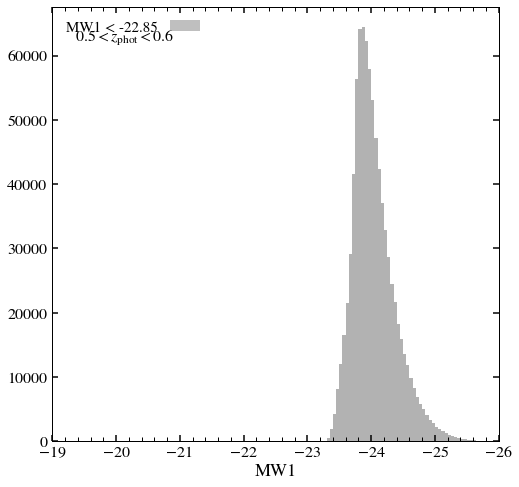

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

abs_mag_bins = np.round(np.arange(-26,-18+0.05,0.05),2)

ax.hist(t[band], bins=abs_mag_bins, color="gray", alpha=0.2, label="")
ax.hist(t[band], bins=abs_mag_bins[abs_mag_bins <= abs_mag_lim+0.05], color="gray", alpha=0.5, label=f"{band} < {abs_mag_lim}")
#ax.hist(t[band], bins=abs_mag_bins, histtype="step", label="$m_z < 20.7$", color="k", lw=1.5)

ax.legend(markerfirst=False)
ax.set_xlim(-19,-26)
ax.set_xlabel(band)

ax.text(*get_corners(ax)["upper_left"], f"${zmin}$" + r"$< z_{\rm phot} <$" + f"$ {zmax}$", ha="left", va="top")

plt.show()


In [80]:
#-- grz DESI depth requirements: 24.0, 23.4, 22.5
#-- Rongpu reliable photo-z cut: apparent z-band mag < 21.0

#-- effective sample number density
areas = get_survey_area(masked=True) #-- (area_north_masked, area_south_masked)
area  = areas[0] if d=="north" else areas[1]

app_mags = t[band[1:]].data
abs_mags = t[band].data

if band=="Mz":
    app_mag_min = 22.50
else:
    app_mag_min = np.nanmax(app_mags)

print(f"{band[1:]}-band apparent magnitude min = {app_mag_min:.2f}")

#-- maximum possbile luminosity distance given magnitude and photometric redshift
dlum_Mpc_max = (10.**( -5. + ( app_mag_min - t[f"M{band[1:]}"] - t[f"K{band[1:]}"] )/5. )).data

zz = np.arange(0, 500, 0.01)
dlum_Mpc = cosmo.luminosity_distance(zz).value

#-- infer redshifts corresponding to these luminosity distances
z_of_dlum_Mpc = interpolate.interp1d(dlum_Mpc, zz, fill_value="extrapolate")

zphot = t["pz"].data

V_zphot  = (cosmo.comoving_volume(zphot) - cosmo.comoving_volume(zmin)).value
zmin_eff = zmin
zmax_eff = np.array([ np.min([ zmax,x ]) for x in z_of_dlum_Mpc(dlum_Mpc_max) ])
V_eff    = (cosmo.comoving_volume(zmax_eff) - cosmo.comoving_volume(zmin_eff)).value

abs_mag_hist,_ = np.histogram(t[band], bins=abs_mag_bins)
gal_counts     = np.cumsum(abs_mag_hist)

ng_eff = [np.sum( 1./(area*V_eff[t[band] < x]) ) for x in abs_mag_bins]

lum_func = dict( abs_mag_bins=abs_mag_bins, ng_eff=ng_eff, gal_counts=gal_counts )

save_as = f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_LRG-{lrg_type}.npy"

print(f"Saving as {save_as}...")
np.save(save_as, lum_func)


W1-band apparent magnitude min = 18.87
Saving as /Users/aberti/Desktop/research/desi_lrg_sham/data/stats/lum_func_MW1_z0p50-0p60_south_zmaglim20p7_LRG-IR.npy...


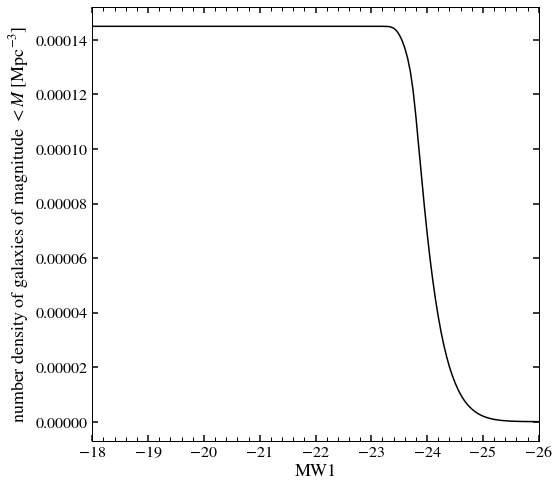

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ng_eff = lum_func["ng_eff"]

ax.plot(abs_mag_bins, ng_eff, color="black")

ax.set_xlim(-18,-26)
ax.set_xlabel(f"{band}")
ax.set_ylabel("number density of galaxies of magnitude $<M$ [Mpc$^{-3}$]")

# ax.semilogy()
# ax.set_ylim(1e-6,1e-2)
plt.show()


<a class="anchor" id="load_halocat"></a>

# Create mock

## Load halo catalog

[BACK TO TOP](#outline)

In [82]:
%%time

################################
##  Load simulation snapshot  ##
################################

quiet = False

a = snaps["scale"][snaps["redshift"]==zsim][0]

halocat_fname = f"{SIMDIR}/{sim_tag}/CATALOGS/hlist_{str(a).replace('.','p')}0_mvir1e11.npy"

if os.path.exists( halocat_fname ):
    if not quiet:
        print(f"Loading {halocat_fname}...")
    halocat = Table( np.load(halocat_fname) )
    
halocat = halocat[np.log10(halocat["mvir"]) >= 11.5]

halocat.sort( sham_tag )

if (halocat[sham_tag][0] < halocat[sham_tag][-1]):
    halocat = halocat[::-1]

assert(halocat[sham_tag][0] > halocat[sham_tag][-1])


Loading /Users/aberti/Desktop/research/sims/mdpl2/CATALOGS/hlist_0p65650_mvir1e11.npy...
CPU times: user 23.1 s, sys: 7.76 s, total: 30.8 s
Wall time: 32 s


In [83]:
%%time

###################################################################
##  Infer halo number densities from target luminosity function  ##
###################################################################

sham_var = halocat[sham_tag]

#-- get value of nh = nh( sham_var ) for each value of sham_var

#-- halo number counts in bins of (log_)sham_var
H,_ = np.histogram( np.log10(sham_var), bins=sham_var_bins )

#-- cumulative halo abundance versus (min log_)sham_var
cdf_log_sham_var = np.max(np.cumsum(H))-np.cumsum(H)

#-- interpolation function for nh of (log_)sham_var
nh_of_log_sham_var = interpolate.interp1d(sham_var_cens,
                                          np.array(cdf_log_sham_var) / (vol_sim/(h**3)),
                                          fill_value="extrapolate")

#-- inferred cumulative halo number densities for sham_var values
nh_inferred = nh_of_log_sham_var( np.log10(sham_var) )

cname = "nh_inferred"
if cname in halocat.colnames:
    halocat.remove_column( cname )
halocat.add_column( Column(nh_inferred, name=cname) )


CPU times: user 1.24 s, sys: 243 ms, total: 1.49 s
Wall time: 1.52 s


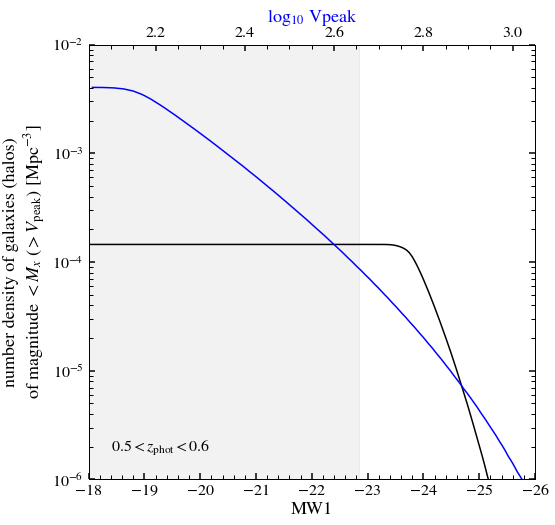

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.semilogy(lum_func["abs_mag_bins"], lum_func["ng_eff"], color="black")

ax.set_xlim(-18,-26)
ax.set_ylim(1e-6,1e-2)
ax.set_xlabel(f"{band}")
ax.set_ylabel("number density of galaxies (halos)\n" + r"of magnitude $<M_x$ ($>V_{\rm peak}$) [Mpc$^{-3}$]")

ax.fill_between((ax.get_xlim()[0],abs_mag_lim), ax.get_ylim()[-1]*np.ones(2), color="gray", alpha=0.1)

ax1 = ax.twiny()

ax1.plot(np.log10(sham_var)[::1], halocat["nh_inferred"][::1], color="blue")
# ax1.scatter(np.log10(sham_var)[::1000], halocat["nh_inferred"][::1000], color="blue", s=2)

ax1.set_xlim(2.05,3.05)
ax1.set_xlabel("$\log_{10}$ Vpeak", color="blue")

ax1.text(*get_corners(ax1, logy=True)["lower_left"], f"${zmin}$" + r"$< z_{\rm phot} <$" + f"$ {zmax}$", ha="left", va="bottom")

plt.show()


In [85]:
###################################################################################
##  Assign luminosities *without* scatter based on inferred halo number density  ##
###################################################################################

#-- get corresponding value of abs_mag for inferred nh values: abs_mag = abs_mag( ngal_eff=nh )
abs_mag_bins = np.round(lum_func["abs_mag_bins"],2)
ngal_eff     = lum_func["ng_eff"]

#-- interpolation function for abs_mag of ngal_eff
abs_mag_of_ngal_eff = interpolate.interp1d(ngal_eff, abs_mag_bins, fill_value="extrapolate")

nh_inferred      = halocat["nh_inferred"]
abs_mag_inferred = abs_mag_of_ngal_eff( nh_inferred )

#-- add inferred magnitudes (with MONOTONIC Vcirc correspondence) to halo catalog
cname = f"{band}_no_scatter"
if cname in halocat.colnames:
    halocat.remove_column( cname )
halocat.add_column( Column(abs_mag_inferred, name=cname) )

halocat[f"{band}_no_scatter"][halocat[f"{band}_no_scatter"] > np.max(abs_mag_bins)] = np.inf


In [86]:
mask = (halocat[f"{band}_no_scatter"] > -np.inf) # & (halocat[f"{band}_no_scatter"] < np.inf)

abs_mag_max = np.min(halocat[f"{band}_no_scatter"][mask])

# halocat[f"{band}_no_scatter"][halocat[f"{band}_no_scatter"] < abs_mag_max] = abs_mag_max


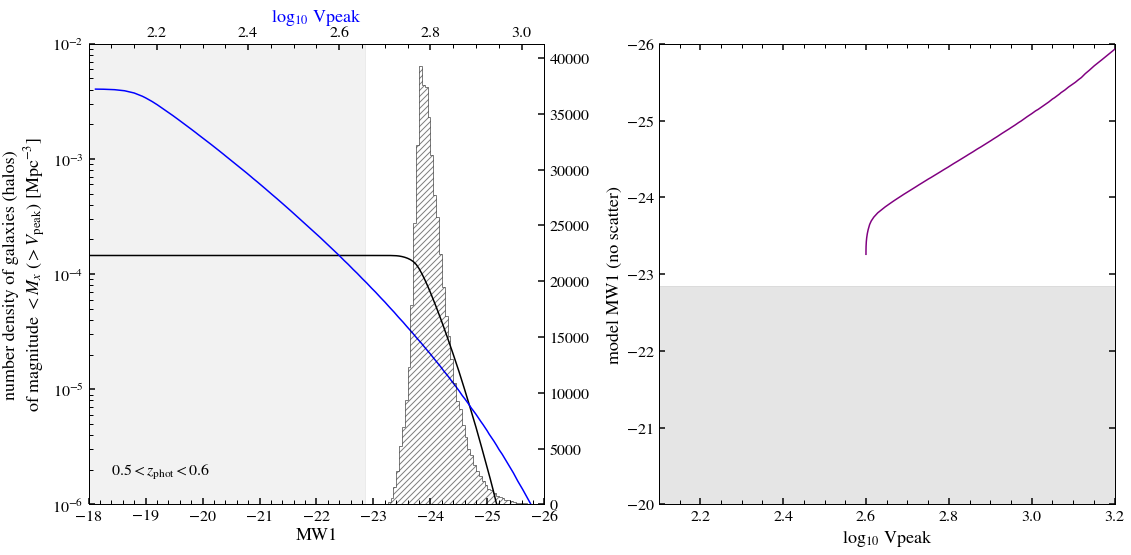

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

ax = axes[0]
ax.semilogy(lum_func["abs_mag_bins"], lum_func["ng_eff"], color="black")

ax.set_xlim(-18,-26)
ax.set_ylim(1e-6,1e-2)
ax.set_xlabel(f"{band}")
ax.set_ylabel("number density of galaxies (halos)\n" + r"of magnitude $<M_x$ ($>V_{\rm peak}$) [Mpc$^{-3}$]")
ax.fill_between((ax.get_xlim()[0],abs_mag_lim), ax.get_ylim()[-1]*np.ones(2), color="gray", alpha=0.1)

ax1 = ax.twiny()
ax1.plot(np.log10(sham_var)[::1000], halocat["nh_inferred"][::1000], color="blue")

ax1.set_xlim(2.05,3.05)
ax1.set_xlabel("$\log_{10}$ Vpeak", color="blue")
ax1.text(*get_corners(ax1, logy=True)["lower_left"], f"${zmin}$" + r"$< z_{\rm phot} <$" + f"$ {zmax}$", ha="left", va="bottom")

ax2 = ax.twinx()
ax2.hist(halocat[f"{band}_no_scatter"], bins=abs_mag_bins, histtype="step", color="k", hatch="////", alpha=0.5)

ax = axes[1]
ax.plot(np.log10(sham_var)[::100], halocat[f"{band}_no_scatter"][::100], color="purple")
# ax.scatter(np.log10(sham_var)[::100], halocat[f"{band}_no_scatter"][::100], s=2)

ax.set_xlim(2.1,3.2)
ax.set_ylim(-20,-26)
ax.set_xlabel("$\log_{10}$ Vpeak")
ax.set_ylabel(f"model {band} (no scatter)")
ax.fill_between(ax.get_xlim(),abs_mag_lim*np.ones(2), color="gray", alpha=0.2)

plt.tight_layout()

plt.show()


<a class="anchor" id="add_scatter"></a>

## Add scattered model magnitudes

[BACK TO TOP](#outline)

In [ ]:
# %%time

# #-- if adding to existing halocat with array of scattered magnitudes

# halocat_fname = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{abs_mag_lim_tag}.npy"

# print(f"Loading {halocat_fname}...")
# halocat = Table(np.load(halocat_fname))


In [88]:
%%time

nsig_clip = 2.5

for sigma_abs_mag in np.arange(0.2,0.21,0.05):

    cname_final = f"{band}_sig{str(np.round(sigma_abs_mag,2)).replace('.','p')}"
    # print(f"{now()} {cname_final}")
    if cname_final not in halocat.colnames:
        #-- add scatter to inferred magnitudes
        abs_mag_inferred_scattered = stats.truncnorm.rvs(-nsig_clip, nsig_clip, halocat[f"{band}_no_scatter"], sigma_abs_mag)

        #-- add inferred magnitudes (with SCATTERED Vcirc correspondence) to halo catalog
        #-- temporary column for intermediate SHAM step
        cname_temp = f"{band}_scattered"
        if cname_temp in halocat.colnames:
            halocat.remove_column( cname_temp )
        halocat.add_column( Column(abs_mag_inferred_scattered, name=cname_temp) )

        halocat.sort( cname_temp )

        abs_mag_inferred_sorted = halocat.copy()[f"{band}_no_scatter"]
        abs_mag_inferred_sorted.sort()

        if cname_final in halocat.colnames:
            halocat.remove_column( cname_final )
        halocat.add_column( Column(abs_mag_inferred_sorted, name=cname_final) )
        

CPU times: user 9.46 s, sys: 842 ms, total: 10.3 s
Wall time: 10.3 s


KeyError: 'MW1_sig0p05'

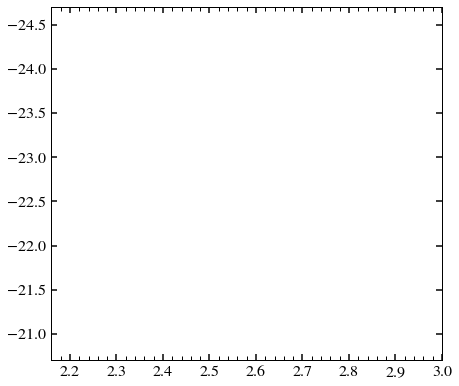

In [89]:
%%time

plt.rcParams["savefig.dpi"] = 200
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.colors as colors

cname_final = f"{band}_sig0p05"
       
fig, ax = plt.subplots(1, 1, figsize=(7,6.5))

ax.set_xlim(2.16,3.0)
ax.set_xticks(np.arange(2.2,3.01,0.1))
ylim = (-20.7,-24.2) if band=="Mz" else (-20.7,-24.7)
ax.set_ylim(ylim)

cmap = plt.get_cmap("binary")

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

new_cmap = truncate_colormap(cmap, 0.0, 0.8)

DS = 1

bins = np.logspace(1.1,6,30)

X, Y = np.log10(halocat[sham_tag])[::DS], halocat[cname_final][::DS]
ax.hexbin(X, Y, gridsize=200, xscale="linear", yscale="linear", cmap=new_cmap, extent=(*ax.get_xlim(), *ax.get_ylim()[::-1]), bins=bins)

line_kwargs = dict(color="magenta", lw=2.5, ls="--")
X.sort()
v = halocat[f"{band}_no_scatter"][::DS].data.copy()
v.sort()
ax.plot(X, v[::-1], **line_kwargs)

# ax.legend( [Line2D([0], [0], **line_kwargs)], ["without scatter"], handletextpad=0.4, handlelength=2, fontsize=24, loc=4, borderpad=0.05)#, framealpha=0.9)
# ymin, ymax = ylim
# yt = ymin + 0.12*(ymax-ymin)
# ax.text(2.97, yt, r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$", ha="right", va="bottom", fontsize=24)#, bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))

ax.set_xlabel(r"$\log_{10}[v_{\rm peak}\ ({\rm km}^{-1}\ {\rm s})]$", fontsize=24)
ylabel = r"${\rm model}\ M_z$" if band=="Mz" else r"${\rm model}\ M_{W1}$"
ax.set_ylabel(ylabel, fontsize=24)
ax.tick_params(axis="both", which="both", labelsize=20)

ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.plot(ax.get_xlim(), abs_mag_lim*np.ones(2), color="k", ls="--")
ax.fill_between(ax.get_xlim(), abs_mag_lim*np.ones(2), color="k", alpha=0.15)

label = r"$z$-band (optical) model" if band=="Mz" else r"$W1$-band (IR) model"
ax.text(*get_corners(ax, margin=0.04)["upper_left"], label, ha="left", va="top", fontsize=24)

plt.tight_layout()

fname = f"{BASEDIR}/figures/vpeak_{cat_tag[:-6]}_{abs_mag_lim_tag}.png"
print(fname)

# plt.savefig(fname, bbox_inches="tight", pad_inches=0.1, dpi=200)

plt.show()


In [90]:
save_as = f"{BASEDIR}/mocks/lrg_only/{zsnap_tag}_{abs_mag_lim_tag}_LRG-{lrg_type}.npy"

print(f"Saving {save_as}...")

np.save(save_as, halocat)


Saving /Users/aberti/Desktop/research/desi_lrg_sham/mocks/lrg_only/zsnap0p52323_MW1limn22p85_LRG-IR.npy...


In [91]:
abs_mag_bins = np.round(lum_func["abs_mag_bins"],2)

print(f"max {lrg_type} LRG number density")
print( np.max( np.array(lum_func["ng_eff"]) ) )
# print("number density at magnitude limit [Mpc^(-3)]:")
# print( np.max( np.array(lum_func["ng_eff"])[np.where(abs_mag_bins <= abs_mag_lim)] ) )

#print(int(np.max( np.array(lum_func["ng_eff"]) ) * (vol_sim/(h**3)) ))
Nhalo_select = int(np.max( np.array(lum_func["ng_eff"])[np.where(abs_mag_bins <= abs_mag_lim)] ) * (vol_sim/(h**3)) )

print("\nnumber of halos to select to achieve target number density:")
print(Nhalo_select)

print(len(halocat[halocat[f"{band}_no_scatter"] <= abs_mag_lim]))


max IR LRG number density
0.00014500652421936165

number of halos to select to achieve target number density:
465881
506972


In [92]:
lrg_type

'IR'

MW1_sig0p2


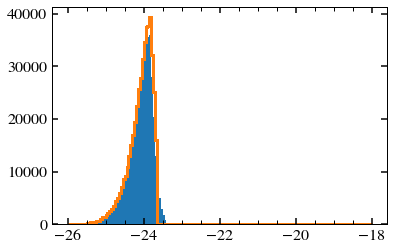

CPU times: user 1.12 s, sys: 377 ms, total: 1.5 s
Wall time: 1.26 s


In [94]:
%%time

sigma_abs_mag = 0.2

sc = str(round(sigma_abs_mag,2)).replace(".","p")
sigma_sham_tag = f"sigma_sham_const{sc}"

abs_mag_cname = f"{band}_sig{str(np.round(sigma_abs_mag,2)).replace('.','p')}"
print(abs_mag_cname)

this_galcat = halocat[ halocat[abs_mag_cname] <= abs_mag_lim ]

#-- sort catalog by model magnitude
this_galcat.sort( abs_mag_cname )
assert(this_galcat[abs_mag_cname][0] < this_galcat[abs_mag_cname][-1])

#-- add column for galaxy flag
if "galaxy" not in this_galcat.colnames:
    this_galcat.add_column( Column(np.zeros(len(this_galcat),dtype=bool), name="galaxy"))

#-- flag halos with galaxies
this_galcat["galaxy"][:Nhalo_select] = True

this_galcat = this_galcat[ this_galcat["galaxy"]==True ]

plt.hist(this_galcat[f"{band}_no_scatter"], bins=abs_mag_bins)
plt.hist(this_galcat[abs_mag_cname], bins=abs_mag_bins, histtype="step", lw=3)

plt.show()


In [95]:
save_as = f"{BASEDIR}/mocks/lrg_only/{zsnap_tag}_{band}_LRG-{lrg_type}_galcat.npy"

np.save(save_as, this_galcat)


In [77]:
def _mock_wp_fast(cat, boxsize=None, sigma_los=None, nthreads=1, pimax=150., bin_file=None, N_iter=1, down_sample=False, quiet=False):
    """
    Corrfunc wp (autocorrelation) calculation of unpadded box using analytic randoms
    """
    out = []
    for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
        xx, yy, zz = cat[u], cat[v], cat[w]

        z_scatter = np.array([np.random.normal(zz, sigma_los, len(zz)) for idx in range(N_iter)])
        z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
        z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)

        if type(down_sample)==int:
            ds = down_sample
            out.append([wp_corrfunc(boxsize, pimax, nthreads, bin_file, xx[::ds], yy[::ds], z_s[::ds], output_rpavg=False)["wp"] for z_s in z_scatter])
        else:
            out.append([wp_corrfunc(boxsize, pimax, nthreads, bin_file, xx, yy, z_s, output_rpavg=False)["wp"] for z_s in z_scatter])

    out = np.concatenate(out).T

    return out


def _run_mock_wp_fast(cat=None, BASEDIR=None, chunk=None, zsnap_tag=None, d=None, pimax=None,
                      sigma_los_const_array=None, quiet=True, band=None, lrg_type=None):
    save_path = f"{BASEDIR}/clustering/mocks/lrg_only/{band}/{sigma_sham_tag}"
    Path( save_path ).mkdir(parents=True, exist_ok=True)

    if lrg_type=="IR":
        save_as = f"{save_path}/{zsnap_tag}_{d}_LXL_pimax{int(pimax)}.npy"
    elif lrg_type=="opt":    
        save_as = f"{save_path}/{zsnap_tag}_{d}_LXLopt_pimax{int(pimax)}.npy"
    else:
        raise Exception()
    if os.path.exists( save_as ):
        wp_all_sigma_los = np.load(save_as, allow_pickle=True).item()
    else:
        wp_all_sigma_los = {}
    for sigma_los in sigma_los_const_array:
        key = f"sigma_los_{sigma_los}"
        if key in wp_all_sigma_los.keys():
            if not quiet:
                print(f"sigma_los = {sigma_los} Mpc/h found; skipping...")
        else:
            wp_this_sigma_los = _mock_wp_fast(cat, boxsize=boxsize, pimax=pimax, bin_file=bin_file_comoving,
                                              quiet=quiet, sigma_los=sigma_los)
            wp  = np.mean(wp_this_sigma_los, axis=1)
            std = np.std(wp_this_sigma_los, axis=1)
            wp_all_sigma_los[key] = dict(rp_mids=rp_mids, wp=wp, std=std)
    np.save( save_as, wp_all_sigma_los, allow_pickle=True )
    

In [ ]:
%%time

if lrg_type=="IR":
    cross = "LXL"
elif lrg_type=="opt":    
    cross = "LXLopt"
else:
    raise Exception()
print(lrg_type)
    
quiet = False

rp_bins, rp_mids = rp_bins_from_file(bin_file_comoving)

sigma_los_const_array = np.arange(50,151,10)

for sigma_abs_mag in np.arange(0.05,0.71,0.05):
    sc = str(round(sigma_abs_mag,2)).replace(".","p")
    sigma_sham_tag = f"sigma_sham_const{sc}"
    
    ##########################################
    ##  Flag (sub)halos with mock galaxies  ##
    ##########################################
    
    abs_mag_cname = f"{band}_sig{str(np.round(sigma_abs_mag,2)).replace('.','p')}"
    print(f"{now()} {abs_mag_cname}")

    this_galcat = halocat[ halocat[abs_mag_cname] <= abs_mag_lim ]
    # print(len(this_galcat))
    
    #-- sort catalog by model magnitude
    this_galcat.sort( abs_mag_cname )
    assert(this_galcat[abs_mag_cname][0] < this_galcat[abs_mag_cname][-1])

    #-- add column for galaxy flag
    if "galaxy" not in this_galcat.colnames:
        this_galcat.add_column(Column(np.zeros(len(this_galcat),dtype=bool), name="galaxy"))

    #-- flag halos with galaxies
    this_galcat["galaxy"][:Nhalo_select] = True
    
    this_galcat = this_galcat[ this_galcat["galaxy"]==True ]
    # print(len(this_galcat))

    kwargs = dict(BASEDIR=BASEDIR, d=d, pimax=pimax, sigma_los_const_array=sigma_los_const_array, quiet=quiet,
                  zsnap_tag=zsnap_tag, band=band, lrg_type=lrg_type)

    kwargs["cat"] = this_galcat
    
    _run_mock_wp_fast(**kwargs)


In [ ]:
sigma_sham_array = np.round(np.arange(0.05,0.71,0.05),2)
sigma_los_array  = np.arange(50,151,10)

if lrg_type=="IR":
    cross = "LXL"
elif lrg_type=="opt":    
    cross = "LXLopt"
else:
    raise Exception()
brightest_mag_bin_rp1Mpch = False

rp_bins, rp_mids = rp_bins_from_file(bin_file_comoving)

abs_mag_bin_tag = "no_abs_mag_bins"

sigma_sham_col = []
sigma_los_col  = []
chisq_col      = []
pct_diff_1h    = []
pct_diff_2h    = []

#-- DATA
fpath    = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/{abs_mag_bin_tag}/wp"
wp_fname = f"{cat_tag}_{cross}_pimax{int(pimax)}.txt"

data   = ascii.read(f"{fpath}/{wp_fname}")
rp_cen = h*data["rp_cen"].data
wp_dat = h*data["wp"].data
wp_err = h*np.sqrt(data["wp_err"].data)

if lrg_type=="IR":
    rp_pi_counts_fname = f"{fpath[:-3]}/rp_pi_counts/{cat_tag}_LXL.npy"
elif lrg_type=="opt":
    rp_pi_counts_fname = f"{fpath[:-3]}/rp_pi_counts/{cat_tag}_LXLopt.npy"
else:
    raise Exception()

cov     = cov_from_rp_pi(rp_pi_counts_fname, cross=cross, rp_mids=rp_mids, pimax=pimax)
cov_inv = np.linalg.inv(cov)

#-- rp bins to include in chisq
rp_use_min, rp_use_max = rp_use_range
if (brightest_mag_bin_rp1Mpch==True) and ("n30p0" in abs_mag_bin_tag):
    if (rp_use_max != None):
        rp_use_idx = np.where((rp_cen > 1.0) & (rp_cen < rp_use_max))[0]
    else:
        rp_use_idx = np.where(rp_cen > 1.0)[0]
else:
    if (rp_use_min != None) & (rp_use_max != None):
        rp_use_idx = np.where((rp_cen > rp_use_min) & (rp_cen < rp_use_max))[0]
    elif (rp_use_min != None) & (rp_use_max==None):
        rp_use_idx = np.where(rp_cen > rp_use_min)[0]
    elif (rp_use_min==None) & (rp_use_max != None):
        rp_use_idx = np.where(rp_cen < rp_use_max)[0]
    else:
        rp_use_idx = np.arange(len(rp_cen))
N_rp = len(rp_use_idx)

rp_use_tag = get_rp_use_tag(rp_use_range, brightest_mag_bin_rp1Mpch=brightest_mag_bin_rp1Mpch,
                            return_tag=True, return_label=False)

#-- MODELS
for sigma_sham in sigma_sham_array:
    sigma_sham_tag = f"sigma_sham_const{str(sigma_sham).replace('.','p')}"
    fpath = f"{BASEDIR}/clustering/mocks/lrg_only/{band}/{sigma_sham_tag}"
    if os.path.exists(fpath):
        wp_fname = f"{zsnap_tag}_{d}_{cross}_pimax{int(pimax)}.npy"

        wp_models = np.load(f"{fpath}/{wp_fname}").item()

        for sigma_los in sigma_los_array:
            sigma_los_key = f"sigma_los_{int(sigma_los)}"
            if sigma_los_key in wp_models.keys():
                #print(sigma_sham, sigma_los)
                wp_mod = Table(wp_models[f"sigma_los_{int(sigma_los)}"])["wp"].data
                chisq  = np.sum([ [ (wp_dat - wp_mod)[i]*cov_inv[i,j]*(wp_dat - wp_mod)[j] for i in rp_use_idx ] for j in rp_use_idx ])

                one_halo = (rp_cen > 0.1) & (rp_cen < 1.0)
                two_halo = (rp_cen > 1.0)
                pct_diff = 1 - wp_mod/wp_dat
                #print( f"{np.mean(pct_diff[one_halo]):.3f} {np.mean(pct_diff[two_halo]):.3f}" )

                sigma_sham_col.append(sigma_sham)
                sigma_los_col.append(sigma_los)
                chisq_int = int(chisq) if (chisq>0) else chisq
                chisq_col.append(chisq_int)
                pct_diff_1h.append(np.round(pct_diff[one_halo],3))
                pct_diff_2h.append(np.round(pct_diff[two_halo],3))

out = Table(data=(chisq_col,sigma_sham_col,sigma_los_col,pct_diff_1h,pct_diff_2h),
            names=("chisq","sigma_sham","sigma_los","pct_diff_1h","pct_diff_2h"))

save_path = f"{BASEDIR}/chisq/lrg_only/{cross}"

save_fname = f"{d}_{sham_tag}_{abs_mag_lim_tag}_{zsnap_tag}.npy"

Path( save_path ).mkdir(parents=True, exist_ok=True)

print(f"Saving {save_path}/{save_fname}...")
np.save(f"{save_path}/{save_fname}", out, allow_pickle=True)
                        

In [ ]:
out.show_in_notebook()


## View parameter surfaces


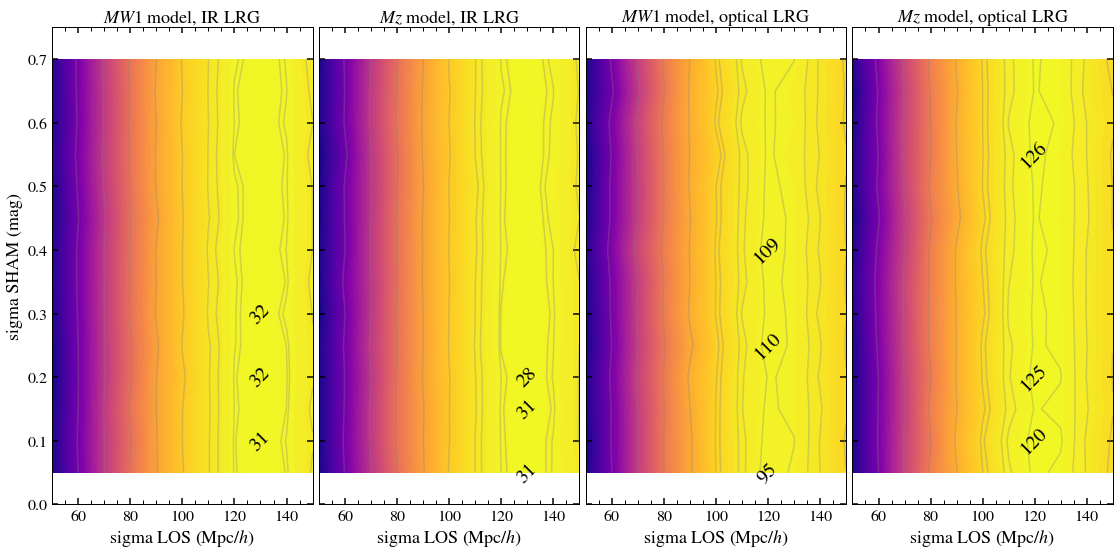

In [17]:
import matplotlib.colors as colors

chisq_fnames = [f"{BASEDIR}/chisq/lrg_only/LXL/south_vpeak_MW1limn22p85_zsnap0p52323.npy",
                f"{BASEDIR}/chisq/lrg_only/LXL/south_vpeak_Mzlimn21p6_zsnap0p52323.npy",
                f"{BASEDIR}/chisq/lrg_only/LXLopt/south_vpeak_MW1limn22p85_zsnap0p52323.npy",
                f"{BASEDIR}/chisq/lrg_only/LXLopt/south_vpeak_Mzlimn21p6_zsnap0p52323.npy"]
                      
fig1, axes = plt.subplots(1,4,figsize=(16,8), sharex=True, sharey=True)
    
y_sham = []
y_los  = []
chisq_val = []

for i,ax in zip(np.arange(4),axes):
    chisq_fname = chisq_fnames[i]
    
    cross = (chisq_fname).split("/")[-2]
    LRG = "optical" if "opt" in cross else "IR"
    band_tag = (chisq_fname).split("/")[-1].split("_")[2][:3]
    if "z" in band_tag: band_tag = "Mz" 
    
    tab = Table(np.load(chisq_fname))
    
    sigma_los  = tab["sigma_los"].data
    sigma_sham = tab["sigma_sham"].data
    chisq      = tab["chisq"].data
    
    zz = chisq.reshape(len(np.unique(sigma_sham)), len(np.unique(sigma_los)))
    
    quant  = np.linspace(0,1,101)
    levels = np.quantile(zz, quant)
    levels_gray  = levels[::-10][::-1]
    levels_black = levels[:2]

    ax.contourf(np.unique(sigma_los), np.unique(sigma_sham), zz, cmap="plasma_r", levels=100)#levels)
    ax.contour(np.unique(sigma_los), np.unique(sigma_sham), zz, colors="gray", alpha=0.3, levels=levels_gray)
    #ax.contour(np.unique(sigma_los), np.unique(sigma_sham), zz, colors="black", linestyles=":", levels=levels_black)

    min1 = np.min(chisq)
    min2 = np.min(chisq[chisq != min1])
    min3 = np.min(chisq[(chisq != min1) & (chisq != min2)])
    min4 = np.min(chisq[(chisq != min1) & (chisq != min2) & (chisq != min3)])
    min5 = np.min(chisq[(chisq != min1) & (chisq != min2) & (chisq != min3) & (chisq != min4)])
    
    mins = np.array([min1,min2,min3])#,min4,min5])
    show = vstack([ tab[chisq==i] for i in mins ])
        
    sigma_los_mins  = show["sigma_los"].data
    sigma_sham_mins = show["sigma_sham"].data

    for i in range(len(mins)):
        ax.text(sigma_los_mins[i], sigma_sham_mins[i], show["chisq"][i], ha="center", va="center", fontsize=20, rotation=45)
    ax.set_title(f"${band_tag}$ model, {LRG} LRG")
    
for ax in axes:
    ax.set_xlabel("sigma LOS (Mpc/$h$)")
    ax.set_ylim(0,0.75)
#    ax.set_xticks(np.arange(*ax.get_xlim(),10))
axes[0].set_ylabel("sigma SHAM (mag)")

plt.tight_layout()
plt.subplots_adjust(wspace=0.025)

plt.show()


In [21]:
%%time

this_MW1lim = get_abs_mag_lim(zmin,"MW1")
this_Mzlim  = get_abs_mag_lim(zmin,"Mz")

this_MW1_abs_mag_lim_tag = get_MW1_tag(this_MW1lim)
this_Mz_abs_mag_lim_tag  = get_Mz_tag(this_Mzlim)

galcat_fname_MW1 = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/color_scatter/{zsnap_tag}_{this_MW1_abs_mag_lim_tag}_galcat-LRG.npy"
galcat_fname_Mz  = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/color_scatter/{zsnap_tag}_{this_Mz_abs_mag_lim_tag}_galcat-LRG.npy"

cat_MW1 = Table(np.load(galcat_fname_MW1))
cat_Mz  = Table(np.load(galcat_fname_Mz))


CPU times: user 2.43 s, sys: 1.74 s, total: 4.17 s
Wall time: 4.29 s


In [22]:
popt = {"MW1":{0.4:(-22.3, -439.2),
               0.5:(21.3, 584.0),
               0.6:(31.2, 839.4),
              },
        "Mz": {0.4:(-11.4, -181.5),
               0.5:(60.9, 1435.6),
               0.6:(50.8, 1248.4),
              },
       }


Mz	0.5	optical LRG selection	(60.9, 1435.6)	csrand
MW1	0.5	optical LRG selection	(21.3, 584.0)	csrand
Mz	0.5	IR LRG selection	(60.9, 1435.6)	csrand
MW1	0.5	IR LRG selection	(21.3, 584.0)	csrand
Mz	0.5	optical LRG-only
MW1	0.5	optical LRG-only
Mz	0.5	IR LRG-only
MW1	0.5	IR LRG-only
/Users/aberti/Desktop/research/desi_lrg_sham/figures/wp_data-vs-mock/sham_lrg_only.png


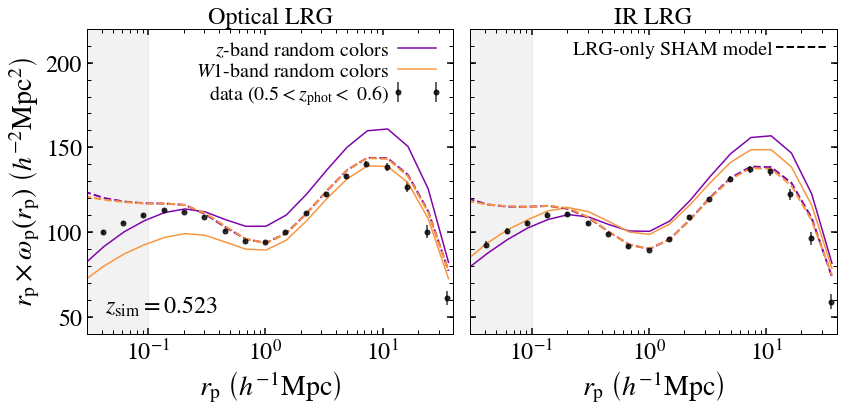

CPU times: user 42.3 s, sys: 3.11 s, total: 45.4 s
Wall time: 43.4 s


In [102]:
%%time

from scipy.signal import savgol_filter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

c_opt, c_IR = get_colors(2)

n_iter   = 1
nthreads = 2
pimax    = 150.
rp_use_range = (0.1,None)
rp_use_min, rp_use_max = rp_use_range
boxsize = get_boxsize("mdpl2")

#-- rp bins used to measure model clustering already have units of comoving Mpc, so do NOT multiply by h
b = ascii.read(bin_file_comoving)
rp_bins = np.concatenate([b["col1"],[b["col2"][-1]]])
rp_mids = 0.5*(rp_bins[1:] + rp_bins[:-1])

fig, axes = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)

for ax in axes:
    ax.semilogx()
    ax.set_xlim(0.03,40)
    ax.set_ylim(40,220)
    ax.tick_params(axis="both", which="major", labelsize=24)
    ax.fill_between((ax.get_xlim()[0],rp_use_min), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)
    ax.yaxis.set_major_locator(MultipleLocator(50))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.set_xlabel(fig_labels["rp"], fontsize=28)

axes[0].set_ylabel(fig_labels["rpwp"], fontsize=28)
        
MW1lim = get_abs_mag_lim(zmin,"MW1")
Mzlim  = get_abs_mag_lim(zmin,"Mz")
MW1_abs_mag_lim_tag = get_MW1_tag(MW1lim)
Mz_abs_mag_lim_tag  = get_Mz_tag(Mzlim)

#-- DATA clustering measurements
for ax,lrg_selection in zip(axes,("opt","IR")):
    cross_data = "LXL" if lrg_selection=="IR" else "LXLopt"
    ax_title = "IR LRG" if lrg_selection=="IR" else "Optical LRG"
    fpath    = f"{BASEDIR}/clustering/zmaglim20p7/{MW1_abs_mag_lim_tag}/no_abs_mag_bins"
    wp_fname = f"{fpath}/wp/{cat_tag}_{cross_data}_pimax{int(pimax)}.txt"
    assert(os.path.exists(wp_fname))
    data = ascii.read(wp_fname)

    #-- units of rp used for data clustering measurements are Mpc (not comoving)
    #-- multiply by h to convert to comoving Mpc and compare to model
    rp_cen = h*data["rp_cen"]
    #-- wp has same units as rp, so multiply by h as well (same for wp error)
    wp_dat = h*data["wp"]
    wp_err = h*np.sqrt(data["wp_err"])

    zphot_label = f"${zmin}$" + r"$<z_{\rm phot}<\ $" + f"${zmin + 0.1}$"
    
    ax.errorbar(rp_cen, rp_cen*wp_dat, yerr=rp_cen*wp_err, label=f"data ({zphot_label})", color="black", marker="o", ms=5, ls="", ecolor="black", alpha=0.8)
    title = "IR LRG" if lrg_selection=="IR" else "Optical LRG"
    ax.set_title(title, fontsize=24)
    
#-- MODEL clustering measurements
galcat_fname_MW1 = f"{BASEDIR}/mocks/mdpl2/vpeak/south/color_scatter/{zsnap_tag}_{MW1_abs_mag_lim_tag}_galcat-LRG.npy"
galcat_fname_Mz  = f"{BASEDIR}/mocks/mdpl2/vpeak/south/color_scatter/{zsnap_tag}_{Mz_abs_mag_lim_tag}_galcat-LRG.npy"

cat_MW1 = Table(np.load(galcat_fname_MW1))
cat_Mz  = Table(np.load(galcat_fname_Mz))

one_halo = (rp_cen > 0.1) & (rp_cen < 1.0)
two_halo = (rp_cen > 1.0)

cs_tag = "csrand"

for ax,lrg_selection in zip(axes,("opt","IR")):
    for this_band,this_mock,color in zip(("Mz","MW1"),(cat_Mz,cat_MW1),(c_opt,c_IR)):

        #-- compute sigma_los for specified parameterization
        m_los, b_los = popt[this_band][zmin]
        sigma_los = m_los*this_mock[this_band].data + b_los
        sigma_los[sigma_los <= 0.0] = 0.0

        #-- "LXL" for IR DESI LRG selection
        if lrg_selection=="IR":
            print(f"{this_band}\t{zmin}\tIR LRG selection\t{m_los,b_los}\t{cs_tag}")
            cross = "LXL"
            lrg_mask = this_mock[f"LRG_IR_{cs_tag}"]==True
        #-- "LXLopt" for optical DESI LRG selection
        elif ("opt" in lrg_selection) | (lrg_selection=="optical"):
            lrg_selection = "opt"
            print(f"{this_band}\t{zmin}\toptical LRG selection\t{m_los,b_los}\t{cs_tag}")
            cross = "LXLopt"
            lrg_mask = this_mock[f"LRG_opt_{cs_tag}"]==True
        else:
            raise Exception()

        out = []
        for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
            xx = this_mock[u][lrg_mask]
            yy = this_mock[v][lrg_mask]
            zz = this_mock[w][lrg_mask]
            z_scatter = np.array([np.random.normal(zz, sigma_los[lrg_mask], len(zz)) for idx in range(n_iter)])
            z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
            z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)

            out.append([wp_corrfunc(boxsize, pimax, nthreads, bin_file_comoving, xx, yy, z_s, output_rpavg=False)["wp"] for z_s in z_scatter])

        out = np.concatenate(out).T

        wp_mean = np.mean(out, axis=1)
        wp_mod  = wp_mean

        labels_cs = {"MW1":r"$W1$-band random colors",# + pct_diff_str,
                     "Mz":r"$z$-band random colors"}# + pct_diff_str}
        ax.plot(rp_mids, savgol_filter(rp_mids*wp_mod,7,3), color=color, label=labels_cs[this_band], ls="-", lw=1.5)

axes[0].legend(numpoints=2, handlelength=2.5, fontsize=20, loc=1, borderpad=0.05, handletextpad=0.15, labelspacing=0.15, markerfirst=False)

#-- SHAM LRG only
for ax,lrg_selection in zip(axes,("opt","IR")):
    for this_band,color in zip(("Mz","MW1"),(c_opt,c_IR)):
        
        this_mock = Table(np.load(f"{BASEDIR}/mocks/lrg_only/{zsnap_tag}_{this_band}_LRG-{lrg_selection}_galcat.npy"))
        #-- compute sigma_los for specified parameterization
        sigma_los = 130*np.ones(len(this_mock)) if lrg_selection=="IR" else 120*np.ones(len(this_mock))

        #-- "LXL" for IR DESI LRG selection
        if lrg_selection=="IR":
            print(f"{this_band}\t{zmin}\tIR LRG-only")
            cross = "LXL"
        #-- "LXLopt" for optical DESI LRG selection
        elif ("opt" in lrg_selection) | (lrg_selection=="optical"):
            lrg_selection = "opt"
            print(f"{this_band}\t{zmin}\toptical LRG-only")
            cross = "LXLopt"
        else:
            raise Exception()

        out = []
        for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
            xx = this_mock[u]
            yy = this_mock[v]
            zz = this_mock[w]
            z_scatter = np.array([np.random.normal(zz, sigma_los, len(zz)) for idx in range(n_iter)])
            z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
            z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)

            out.append([wp_corrfunc(boxsize, pimax, nthreads, bin_file_comoving, xx, yy, z_s, output_rpavg=False)["wp"] for z_s in z_scatter])

        out = np.concatenate(out).T

        wp_mean = np.mean(out, axis=1)
        wp_mod  = wp_mean

        ax.plot(rp_mids, savgol_filter(rp_mids*wp_mod,7,3), color=color, ls="--", lw=2)#, label="SHAM with LRG-only")

zsim_label = r"$z_{\rm sim}=$" + f"${zsim:.3f}$"
axes[0].text(*get_corners(ax, logx=True, margin=0.05)["lower_left"], zsim_label, fontsize=24, va="bottom", ha="left")

handles = [Line2D([0], [0], color="black", lw=2, ls="--")]
axes[1].legend(handles, ["LRG-only SHAM model"], handlelength=2.5, fontsize=20, loc=1, borderpad=0.05, handletextpad=0.15, labelspacing=0.15, markerfirst=False)

plt.tight_layout()

figname = f"{BASEDIR}/figures/wp_data-vs-mock/sham_lrg_only.png"
print(figname)

plt.savefig(figname, dpi=200, bbox_inches="tight", pad_inches=0.1)

plt.show()
    